# Difference-in-difference in a repeated cross-sample

See the [did repo](https://github.com/vvoutilainen/Data_Science_Projects/tree/master/stats/did) for updated notebooks and source code.

## Background

Assume we are measuring observations for a repeated cross-sample of $N=600$ individuals (e.g., customers at a marketing platform, new bank loans, etc.) at time points $t = 0, 1, \cdots 19$. There are two distinguished groups of individuals ($j=C,T$), for example, from two different areas.

Imagine that in one of the areas there is a one-off intervention (e.g., a government stimulus package) taking place between time points 2 and 3 that might affect a feature of interest ("outcome") of the individuals (e.g., time spent on the site, pricing of the loans). We are interested in the **treatment effect** of the intervention on the outcome.

## Data-generating process

We consider a data-generating process (DGP) of the following form:

$$
\begin{equation*}
    Y_{ijt}^0 = \gamma_j + \xi_t + \lambda_t X_{ijt} + \epsilon_{it}
\end{equation*}
$$

where

 - $\gamma_j$ is a group-specific, time-invariant effect;
 - $\xi_t$ is a time-specific effect (affecting all individuals/groups the same way);
 - $X_{ijt}$ is an individual-group-time-specific effect. $\lambda_t$ denotes the (possibly time-varying) effect of $X_{ijt}$;
 - $\epsilon_{it}$ denote individual-and-time-specific idiosyncrasies.

The effect of the intervention is modeled as an additive effect:

$$
\begin{equation*}
    Y_{ijt}^1 = Y_{ijt}^0 + \tau_{jt} ,
\end{equation*}
$$

where $\tau_{jt}$ is the (possibly group- and time-dependend) treatment effect. We allow for either a constant or a linearly evolving $\tau_{jt}$. See the notebook *did_simulated_datasets.ipynb* in the [did repo](https://github.com/vvoutilainen/Data_Science_Projects/tree/master/stats/did) for more in-depth explanation of the DGP.

Notice that, **in reality, the true data-generating process is unknown to the researcher**! Here we use simulated data (properties of which we know) to help us understand the properties of our research design and regression models. As advocated by [Gelman, Hill and Vehtari (2020, section 5.5)](https://avehtari.github.io/ROS-Examples/), fake-data simulation is a "way of life" to evaluate the statistical methods.

## Research design

Assume we are interested in the average **treatment effect on the treated** (ATT). That is, we would like to know how much the intervention affected (on average) the outcome for individuals in the treated group. We can write this **estimand** in mathematical form using potential outcome notation:

$$
\begin{equation*}
    \theta = E[Y_{i}^1(post) - Y_{i}^0(post) \ | \ j=T]
\end{equation*}
$$

where 

 - $Y_{i}^d(post)$ denotes the potential outcome of an individual $i$ at post-period under treatment $D=d$;
 - expectation operator is to be understood to average over individuals $i$ (and over $t$ since our estimation is done at the level of pre/post periods instead of individual time points);
 - the post-period consist of time points 10-19 (and the pre-period of time points 0-9).
 
## Some references for DiD:

 - [DiD on Health Policy Data Science](https://diff.healthpolicydatascience.org/)
 - [My flashcard](https://raw.githubusercontent.com/NoobQuant/Data_Science_Projects/master/flashcards/diff_in_diff.jpg)
 
## Technical details for running the notebook

Used conda environment is `dev2023a` from [here](https://github.com/vvoutilainen/dsenvs/blob/main/condaenv.md). Additionally installed packages:

 - *r-dagitty* via conda/mamba: `mamba install r-dagitty`. Also installs dependencies.

## Imports

In [1]:
# Python dependencies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
np.random.seed(1337)

# Local helpers
from did_helpers import(
    simulate_did_data,
    plot_repcrossec_data,
    parallel_trends_plot,
    dynamic_did_plot,
)

# R interface
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(dagitty)

## Helper functions

In [3]:
def prepare_static_regression_frame(data):

    df = data["observed"].copy()
    
    # Possible interaction between time and X if X present
    if "X" in df.columns:
        df["X_time"] = df["X"] * df["t"]
    
    # Code categories as dummies
    df["dummy_period"] = df["time_group"].map({
        "before": 0,
        "post": 1,
    })
    df["dummy_group"] = df["treatment_group"].map({
        "control": 0,
        "treatment": 1,
    })
    df["dummy_group_x_period"] = df["dummy_period"] * df["dummy_group"]
    
    # Time points as categorical/str
    df["t"] = df["t"].astype(str)

    return df

def prepare_dynamic_regression_frame(data):

    df = data["observed"].copy()
    param_last_pre_timepoint = data["params"]["param_last_pre_timepoint"]
    
    # Variable measuring periods to first treatment time 
    df["time_to_treat"] = (
        df["t"]
        .sub(param_last_pre_timepoint+1)
        .astype('int')
    )

    # We want to create "treatment" dummies from the time_to_treat column such that the kth dummy
    # obtains value 1 for a given observation if the period of the observation equals k.

    # To this end, first set time_to_treat cor control observations to 0, as the treatment
    # dummy values need to be zero for them.
    df.loc[df["treatment_group"]=="control", "time_to_treat"] = 0

    # Now create the "dynamic" dummies from time_to_treat. Drop out the last time point before treatment
    # manually to avoid multicolinearity problems (this sets the last time point before treatment as a
    # reference) point.
    df = (
        pd.get_dummies(
            df,
            columns=["time_to_treat"],
            prefix="dummy_group_x_period",
            drop_first=False
        )
        .rename(columns=lambda x: x.replace('-', 'm'))
        .drop(columns="dummy_group_x_period_m1")
    )

    # Time points as categorical/str
    df["t"] = df["t"].astype(str)

    return df

## Classical two-period DiD

We start with a specification where in the true data generating process there is no effect $\lambda_t X_{ijt}$.

### Simulate and plot data

Realized control pre-period mean 8.509
Realized control post-period mean 18.498
Realized treated pre-period mean 5.497
Realized treated post-period mean 13.491
Counterfactual (unobserved) treatment post-period mean 15.491
Counterfactual (naively estimated) treated post-period mean 15.486
Naive DiD-estimate -1.995


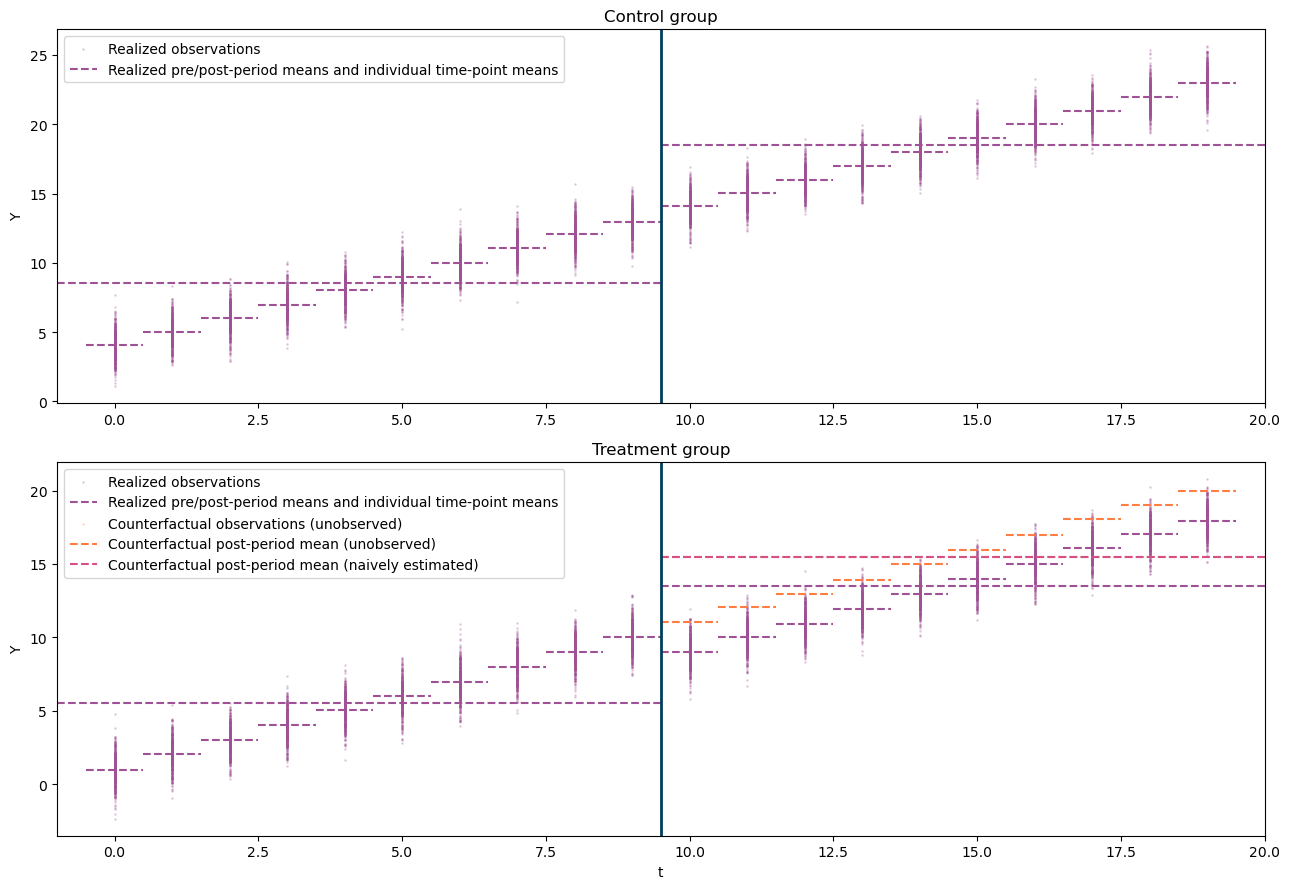

In [4]:
# Simulate
data_1 = simulate_did_data(
    param_datasettype="repeated cross-section",
    param_no_t=20,
    param_N=1000,
    param_gamma_c=4,
    param_gamma_t=1,
)

# Plot
plot_repcrossec_data(data_1)

### Research design

Represent the research design as a directed acyclical graph. Explanation of the arrows:

 - Intervention affects individuals in the treated group but only in the post period. Hence, there is an arrow $D_{it} \rightarrow Y_{i, post}$.
 - Time fixed effects $\xi_t$ affect outcomes in each time point of pre and post periods ($\xi_t \rightarrow Y_{i,pre}$ and $\xi_t \rightarrow Y_{i,post}$).
 - $Y_{i,pre}$ and $Y_{i,post}$ trivially affect their difference, hence the arrows $Y_{i,pre} \rightarrow Y_{i,post} - Y_{i,pre}$ and $ Y_{i,post} \rightarrow Y_{i,post} - Y_{i,pre}$.
 - Group-level effect $\gamma_j$ acts as a *confounder* in cross-sectional dimension: it causes* the treatment assignment to treatment/control groups ($\gamma_j \rightarrow D_{it}$) as well as the outcome in each time point of pre and post periods ($\gamma_j \rightarrow Y_{i,pre}$ and $\gamma_j \rightarrow Y_{i,post}$). Due to this, we could not simply compare $E[Y_{it} | j=T]$. The DiD estimator automatically controls for time-invariant, group specific effects via the double differencing. Hence, as [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666) define it, $\gamma_j$ does **not** constitute a confounder in a multi-period DiD setting. In order for a time-invariant group-specific covariate to be a confounder, "*the means of the covariate are different in the two groups and it has time-varying effect on the outcome*" ([Zeldow & Hatfield, 2021, p. 934](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666)).

\**Side note: This is not entirely true in our data generating process: the treatment assignment probability is a constant, user-defined parameter. However, we make the mean value of $\gamma_j$ differ between groups $j$, essentially mimicking a scenario where individual observations with higher/lower value of $\gamma_j$ are more likely to appear in the treatment group*.

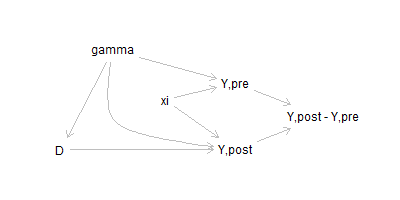

In [5]:
%%R -h 200 -w 400
g = dagitty('
    dag {
    " " [pos="-1.0, 0"]
    "" [pos="1.0, 1"]
    "D" [pos="-0.8, 0.8"]
    "Y,pre" [outcome,pos="0.2, 0.4"]
    "Y,post" [outcome,pos="0.2, 0.8"]
    "Y,post - Y,pre" [outcome,pos="0.7, 0.6"]
    "gamma" [adjusted,pos="-0.5, 0.2"]
    "xi" [pos="-0.2, 0.5"]
    "D" -> "Y,post"
    "gamma" -> "D"
    "gamma" -> "Y,post" [pos="-0.6, 0.7"]
    "gamma" -> "Y,pre"
    "Y,pre" <- "xi" -> "Y,post"
    "Y,pre" -> "Y,post - Y,pre" <- "Y,post"
    }
')
plot(g)

### Parallel trends assumption

The most important assumption behind the DiD design is the *parallel trend assumption*, which assumes that there are no confounding effects in the DiD setting as [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666) define them. In this particular case, we have assumed a DGP where there are only group invariant ($\xi_t$) and time-invariant ($\gamma_j$) effects, which means that the parallel trends assumption holds.

Sometimes the use of parallel trends assumption is validated by looking into the pre-period evolution of the average $E[Y_{it}]$ over $t$ between the treatment and control groups. The evolution of these averages can be eyeballed from the plot above (vertical short dashed lines), but let's draw the averages in a more convenient plot for better comparison. From the plot it becomes obvious that the DGP has the same pre-trend (on average).

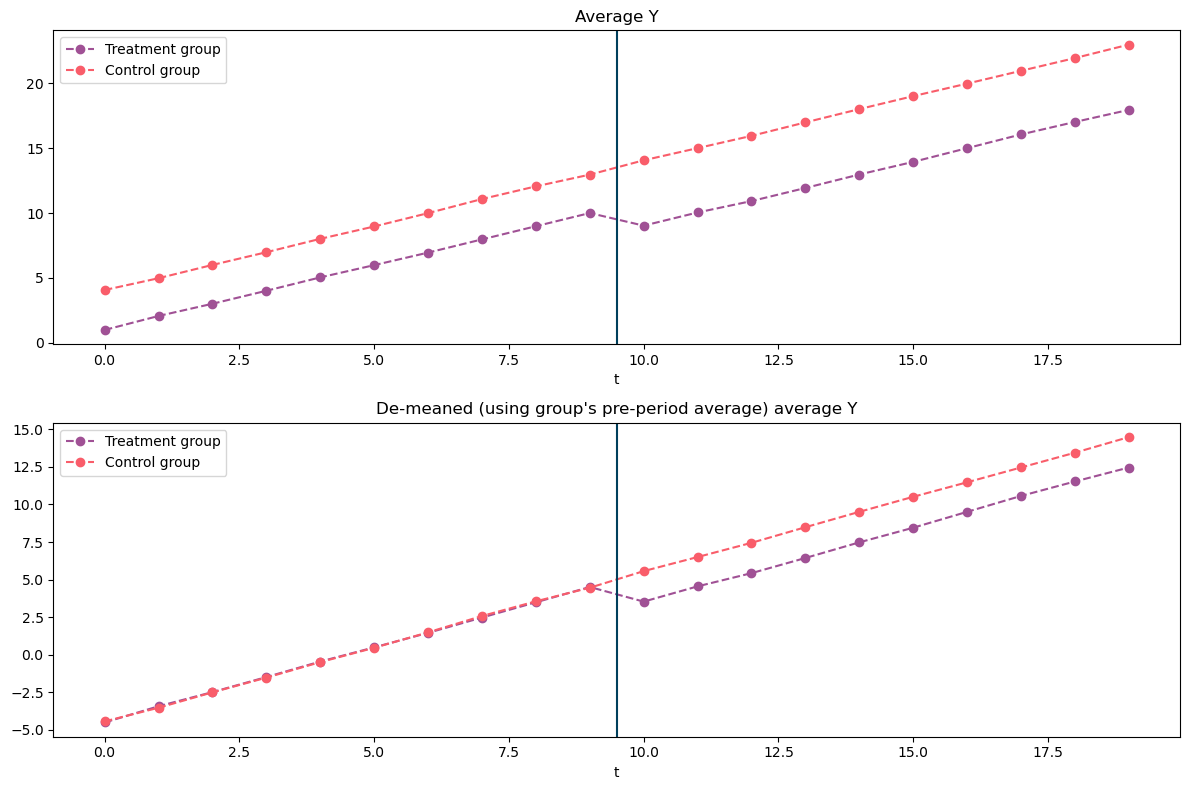

In [6]:
parallel_trends_plot(data_1)

### "Static" regression

Since we have a well-defined, one-off intervention without anticipation, well-defined treatment/control groups as well as the parallel trends assumption holds, we can use a **classical, static difference-in-difference (DiD)** estimator to estimate $\theta$. The hope is to recover the correct estimate $\tau = -2$.

To estimate the ATT estimand defined above, we can construct an estimator (see the [flashcard](https://raw.githubusercontent.com/NoobQuant/Data_Science_Projects/master/flashcards/diff_in_diff.jpg)) which is effectively a **two-way fixed effects estimator (TWFE)**. It can be employed using the following regression equation:

$$
\begin{equation*}
    y_{ijt} = \alpha + \beta_1 \ dummy\_group + \beta_2 \ dummy\_period + \beta_3 \ dummy\_group\_x\_period + \epsilon_{it}
\end{equation*}
$$

where

 - $\alpha$ is an intercept;
 - $\epsilon_{it}$ is a residual term;
 - `dummy_group` denotes a dummy variable that obtains value 1 when $j=T$ and otherwise zero;
 - `dummy_period` denotes a dummy variable that obtains value 1 when $t>2$ (post-period) and otherwise zero;
 - `dummy_group_x_period` denotes the interaction of `dummy_group` and `dummy_period`. 

This estimator will deal with the group-level confounding $\gamma_j$.

In [7]:
df = prepare_static_regression_frame(data_1)
reg_str = "Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 1.775e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:18:08   Log-Likelihood:                -50565.
No. Observations:               20000   AIC:                         1.011e+05
Df Residuals:                   19996   BIC:                         1.012e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In the above regressions we are controlling for group fixed effects (`dummy_group`) and time fixed effects (`dummy_period`). Notice that typically in the econometric literature regression for a TWFE is written using time/group fixed effects for **all** time points and groups:

$$
\begin{equation*}
    y_{ijt} = \eta_j + \nu_t + \beta_3 \ dummy\_group\_x\_period + \epsilon_{it}
\end{equation*}
$$

where

 - $\eta^j$ denotes group fixed effects (we only have two, control and treatment);
 - $\nu_t$ denotes time fixed effects.

As we will see below, this makes no difference for the DiD coefficient estimate.* However, standard errors and thus significance bounds differ a bit due to differing degrees of freedom.

*\*Time fixed effects will become essential for the coefficient estimate when the intervention is staggered, see for example [this](https://stats.stackexchange.com/questions/455986/panel-data-diff-in-diff-and-the-pattern-of-the-binary-treatment-indicator)*.

In [8]:
reg_str = "Y ~ -1 + treatment_group + t + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 3.174e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:18:08   Log-Likelihood:                -28177.
No. Observations:               20000   AIC:                         5.640e+04
Df Residuals:                   19978   BIC:                         5.657e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
treatment_group[cont

### "Dynamic" regression

This section draws from the [LOST dynamic DiD page](https://lost-stats.github.io/Model_Estimation/Research_Design/event_study.html).

Now we perform the "dynamic" version of the DiD regression, sometimes also called "DiD event study". Dynamic DiD is useful in evaluating treatment effects of the pre- and post- treatment periods. The event-dtudy plot one can get out of the dynamic DiD version can be informative.

The regressions looks like

\begin{align*}
y_{ijt} = \eta_j + \nu_t + \sum_{k=T_l}^{g-1} \beta_k \ dummy\_group\_x\_period_k + \sum_{k=g+1}^{T_h} \beta_k \ dummy\_group\_x\_period_k + \epsilon_{it}
\end{align*}

where $T_l < g-1$ and $T_h \leq T$ are the time points defining the lenghts of the "event window" in the dynamic DiD setup. We estimate the coefficients for all periods, that is, $T_l = 0$ and $T_h = T$. Notice that the last pre-treatment time point has been omitted from the treatment dummies to avoid multicolinearity issues.

Below we see that the regressions recovers correct estimates: in the pre-period, estimated effects are zero in each period, whereas in the post period we obtain estimates around -2 for each period.

In [10]:
df = prepare_dynamic_regression_frame(data_1)
reg_str = "Y ~ -1 + treatment_group + t + " + " + ".join(df.columns[df.columns.str.contains("dummy_group_x_period")])
res = smf.ols(reg_str, data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.709e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:18:09   Log-Likelihood:                -28169.
No. Observations:               20000   AIC:                         5.642e+04
Df Residuals:                   19960   BIC:                         5.673e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
treatment_group[cont

Let's deemonstrate the results in an event-study plot.

Average treatment effect, pre: -0.05 (should be zero!).
Average treatment effect, post: -2.04.


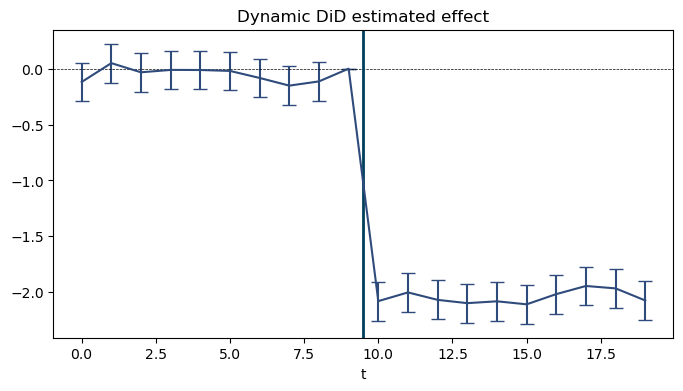

In [11]:
dynamic_did_plot(
    res,
    data_1["params"]["param_last_pre_timepoint"]
)

## Classical two-period DiD with time-variant, group-divergent covariate

Now we introduce a time-variant effect $x_{ijt}$ that a) is similar to $\gamma_j$ in that it causes treatment assignment* in pre-period. In addition, the covariate evolves differently between treatment and control groups but its effect on the outcome remains constant.

\**Same caveat as above applies.*

### Simulate and plot data

Realized control pre-period mean 6.883
Realized control post-period mean 8.899
Realized treated pre-period mean 8.436
Realized treated post-period mean 18.415
Counterfactual (unobserved) treatment post-period mean 20.415
Counterfactual (naively estimated) treated post-period mean 10.452
Naive DiD-estimate 7.964


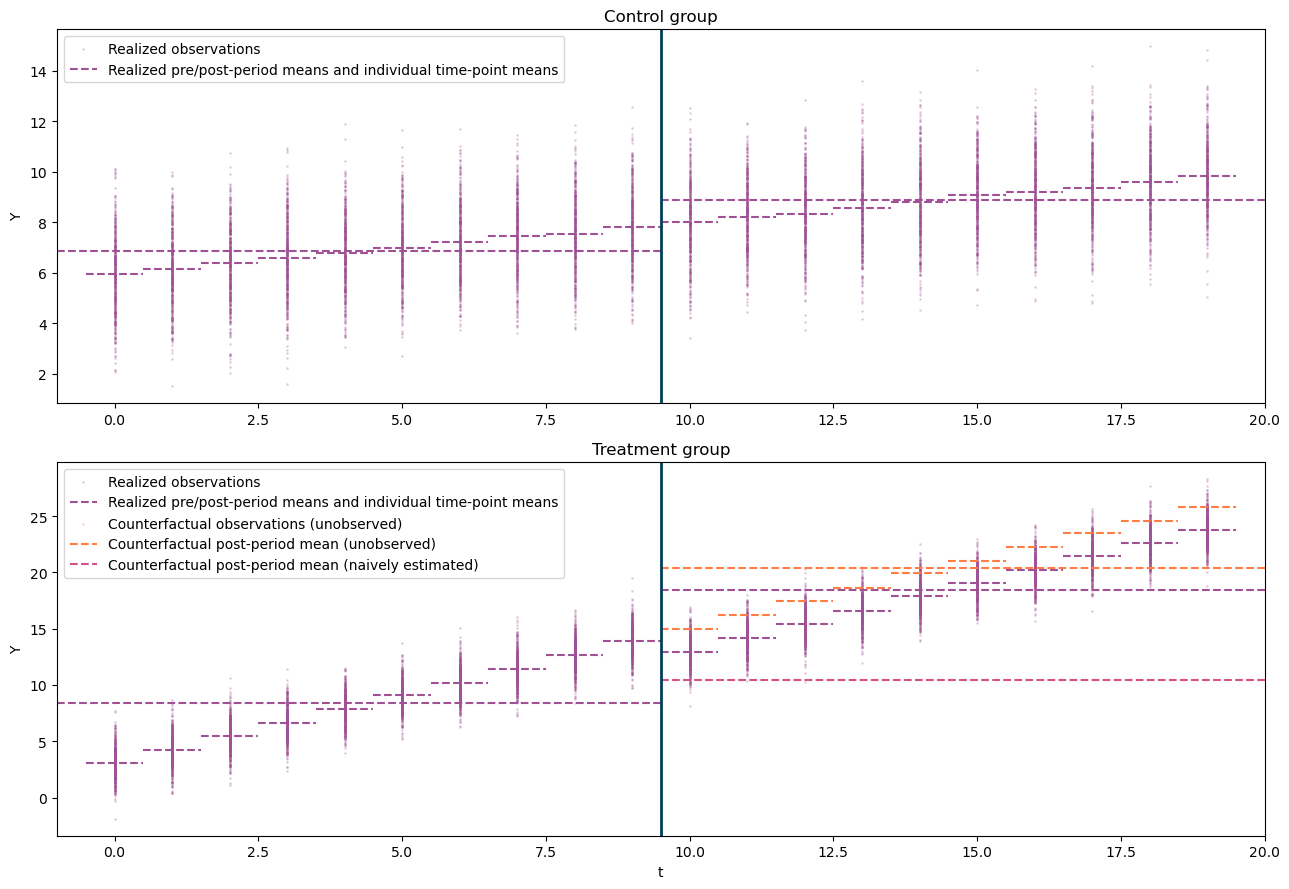

In [12]:
# Simulate
data_2 = simulate_did_data(
    param_datasettype="repeated cross-section",
    param_no_t=20,
    param_N=1000,
    param_gamma_c=4,
    param_gamma_t=1,
    param_xi=lambda t: 0.7*t,
    param_xtype="X5a",
    param_x_kwargs = {
        "param_mu_T": 2,
        "param_sigma_T": 1,
        "param_mu_C": 2,
        "param_sigma_C": 1,
        "param_trendcoef_T": 0.5,
        "param_trendcoef_C": -0.5
    }
)

# Plot
plot_repcrossec_data(data_2)

### Reseach design

In this case the covariate $X_{it}$ is time-varying. Hence, we draw both $X_{pre}$ and $X_{post}$ into the DAG. Covariate values start from different level in both groups $j$ at $t=0$, hence $X_{pre} \rightarrow D$.* Further, evolution of the covariate means differ between treatment and control groups. This is indicated by the arrow $D \rightarrow X_{post}$.

In order to close the backdoor paths from $D$ to $Y_{post} - Y_{pre}$, we need to control for both $X_{pre}$ and $X_{post}$, that is, $X_{t}$. The naive DiD estimator will not do this for us! Notice that since the effect of $X_{it}$ on outcome is time-invariant, we do not need to interact the covariate with time ([here](https://diff.healthpolicydatascience.org/)).

\**Imagine we instead assumed that the covariate starts from the same levels between treatment and control groups in pre-period. In this case the covariate would still be a confounder in DiD setting due to diverging evolution, but here I'm having a hard time to justify arrow $X_{pre} \rightarrow D$. This arrow is, however, essential if we insist on a DAG to represent the confounding effect of the covariate on the outcome, which we know it will have. The article [here](https://diff.healthpolicydatascience.org/), based on [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666), elude this point in DAGs presented. In conclusion, DAGs might not always be an appropriate in communicating confounding in a DiD setting.*

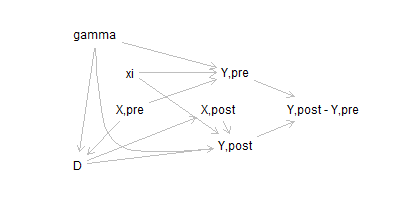

In [13]:
%%R -h 200 -w 400
g = dagitty('
    dag {
    " " [pos="-1.0, 0.1"]
    "" [pos="1.0, 1.0"]
    "D" [pos="-0.7, 0.9"]
    "Y,pre" [outcome,pos="0.2, 0.4"]
    "Y,post" [outcome,pos="0.2, 0.8"]
    "Y,post - Y,pre" [outcome,pos="0.7, 0.6"]
    "gamma" [adjusted,pos="-0.6, 0.2"]
    "xi" [pos="-0.4, 0.4"]
    "X,pre" [pos="-0.4, 0.6"]
    "X,post" [pos="0.1, 0.6"]
    "D" -> "Y,post"
    "gamma" -> "D"
    "gamma" -> "Y,post" [pos="-0.6, 0.9"]
    "gamma" -> "Y,pre"
    "Y,pre" <- "xi" -> "Y,post"
    "Y,pre" -> "Y,post - Y,pre" <- "Y,post"
    "X,pre" -> "Y,pre"
    "X,post" -> "Y,post"
    "X,pre" -> "D" -> "X,post"
    }
')
plot(g)

### Parallel trends assumption

We see a clear violation of the parallel trends assumption in the pre-trends.

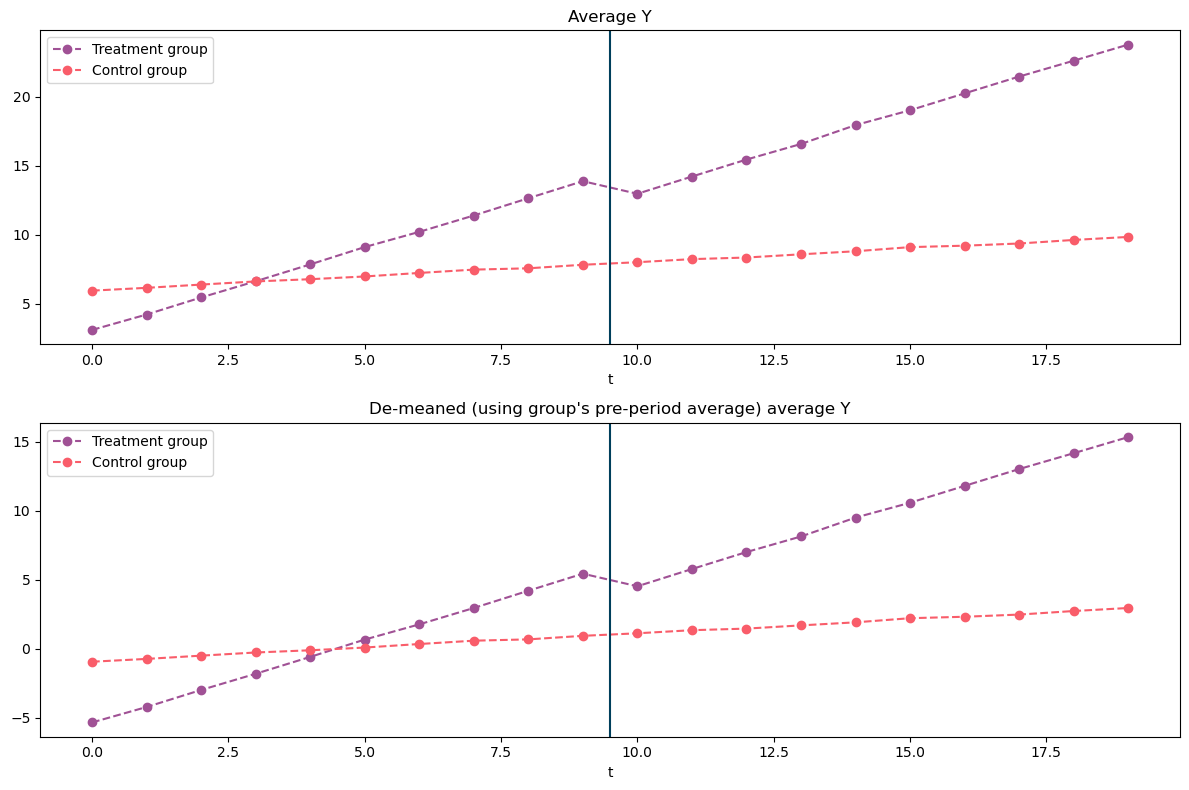

In [14]:
parallel_trends_plot(data_2)

### Regressions

#### Naive DiD

Naive DiD regression yields a biased result in the presence of the divergent time-varying confounder.

In [15]:
df = prepare_static_regression_frame(data_2)
reg_str = "Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + dummy_group + dummy_period + dummy_group_x_period

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:18:11   Log-Likelihood:                -49468.
No. Observations:               20000   AIC:                         9.894e+04
Df Residuals:                   19996   BIC:                         9.898e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

#### Adjust for the covariate

When we adjust for the covariate, we recover a correct estimate. The estimate is not totally accurate, most probably due to the nature of our DGP. If we simulated multiple datasets and took the average DiD estimate on those, we should get to the correct ATT on average.

In [16]:
df = prepare_static_regression_frame(data_2)
reg_str = reg_str = "Y ~ 1 + X + dummy_group + dummy_period + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + X + dummy_group + dummy_period + dummy_group_x_period

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                 2.370e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:18:11   Log-Likelihood:                -44582.
No. Observations:               20000   AIC:                         8.917e+04
Df Residuals:                   19995   BIC:                         8.921e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

## Classical two-period DiD with trend in treatment effect

Realized control pre-period mean 8.508
Realized control post-period mean 18.514
Realized treated pre-period mean 5.485
Realized treated post-period mean 12.742
Counterfactual (unobserved) treatment post-period mean 15.492
Counterfactual (naively estimated) treated post-period mean 15.491
Naive DiD-estimate -2.749


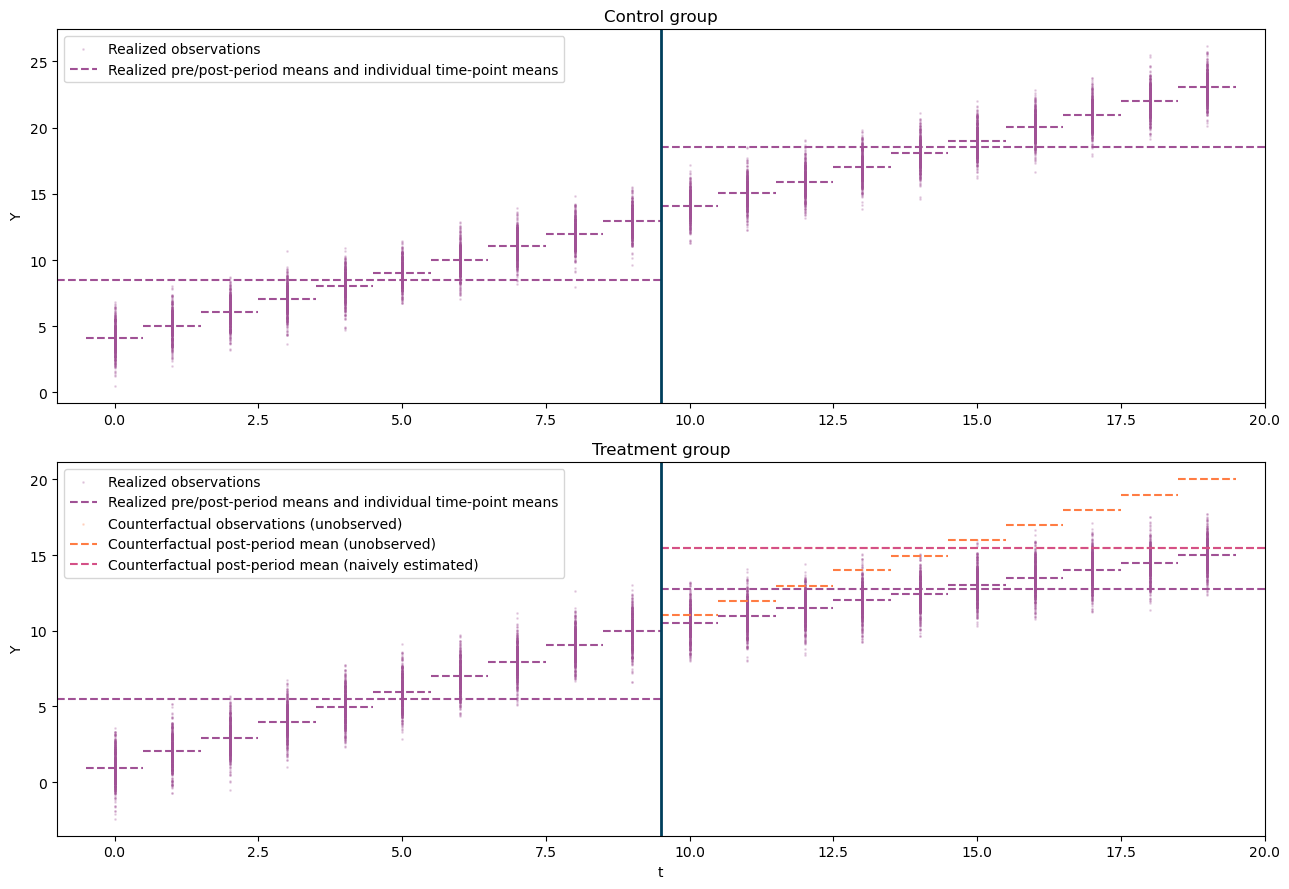

In [19]:
# Simulate
data_1 = simulate_did_data(
    param_datasettype="repeated cross-section",
    param_no_t=20,
    param_N=1000,
    param_gamma_c=4,
    param_gamma_t=1,
    param_tau=-0.5,
    param_treat_eff_trend=True,
)

# Plot
plot_repcrossec_data(data_1)

In [18]:
df = prepare_static_regression_frame(data_1)

reg_str = "Y ~ -1 + treatment_group + t + dummy_group_x_period"
res = smf.ols(reg_str, data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 2.262e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:31:57   Log-Likelihood:                -30741.
No. Observations:               20000   AIC:                         6.153e+04
Df Residuals:                   19978   BIC:                         6.170e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
treatment_group[cont

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.574e+04
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:34:47   Log-Likelihood:                -28197.
No. Observations:               20000   AIC:                         5.647e+04
Df Residuals:                   19960   BIC:                         5.679e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
treatment_group[cont

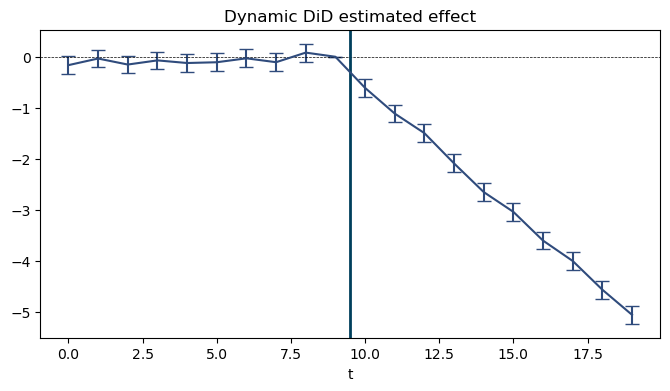

In [21]:
df = prepare_dynamic_regression_frame(data_1)
reg_str = "Y ~ -1 + treatment_group + t + " + " + ".join(df.columns[df.columns.str.contains("dummy_group_x_period")])
res = smf.ols(reg_str, data=df).fit()
print(res.summary())

dynamic_did_plot(
    res,
    data_1["params"]["param_last_pre_timepoint"]
)